In [2]:
import os; os.environ['OPENBLAS_NUM_THREADS']='1'
import numpy as np
import pandas as pd
import implicit
from scipy.sparse import coo_matrix
from implicit.evaluation import mean_average_precision_at_k

In [3]:
# article = pd.read_csv("articles.csv", dtype={'article_id': str})
# customer = pd.read_csv("customers.csv")
# sample_submission = pd.read_csv("sample_submission.csv")
transaction_train = pd.read_csv("transactions_train.csv",dtype={'article_id': str}, parse_dates=['t_dat'])

In [4]:
print(min(transaction_train['t_dat']),max(transaction_train['t_dat']))

2018-09-20 00:00:00 2020-09-22 00:00:00


In [5]:
df = transaction_train[transaction_train['t_dat']>='2020-09-01']
df.shape

(798269, 5)

In [6]:
pd.options.mode.chained_assignment = None

In [7]:
ALL_USERS = df['customer_id'].unique().tolist()
ALL_ITEMS = df['article_id'].unique().tolist()

user_ids = dict(list(enumerate(ALL_USERS)))
item_ids = dict(list(enumerate(ALL_ITEMS)))

user_map = {u: uidx for uidx, u in user_ids.items()}
item_map = {i: iidx for iidx, i in item_ids.items()}

df['user_id'] = df['customer_id'].map(user_map)
df['item_id'] = df['article_id'].map(item_map)

# del customer, article

In [8]:
row = df['user_id'].values
col = df['item_id'].values
data = np.ones(df.shape[0])
coo_train = coo_matrix((data, (row, col)), shape=(len(ALL_USERS), len(ALL_ITEMS)))
coo_train

<189510x26252 sparse matrix of type '<class 'numpy.float64'>'
	with 798269 stored elements in COOrdinate format>

In [9]:
%%time
model = implicit.als.AlternatingLeastSquares(factors=10, iterations=2)
model.fit(coo_train)

C:\Users\siyuf\anaconda3\lib\site-packages\implicit\utils.py:31: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

Wall time: 650 ms


In [10]:
def to_user_item_coo(df):
    """ Turn a dataframe with transactions into a COO sparse items x users matrix"""
    row = df['user_id'].values
    col = df['item_id'].values
    data = np.ones(df.shape[0])
    coo = coo_matrix((data, (row, col)), shape=(len(ALL_USERS), len(ALL_ITEMS)))
    return coo


def split_data(df, validation_days=7):
    """ Split a pandas dataframe into training and validation data, using <<validation_days>>
    """
    validation_cut = df['t_dat'].max() - pd.Timedelta(validation_days)

    df_train = df[df['t_dat'] < validation_cut]
    df_val = df[df['t_dat'] >= validation_cut]
    return df_train, df_val

def get_val_matrices(df, validation_days=7):
    """ Split into training and validation and create various matrices
        
        Returns a dictionary with the following keys:
            coo_train: training data in COO sparse format and as (users x items)
            csr_train: training data in CSR sparse format and as (users x items)
            csr_val:  validation data in CSR sparse format and as (users x items)
    
    """
    df_train, df_val = split_data(df, validation_days=validation_days)
    coo_train = to_user_item_coo(df_train)
    coo_val = to_user_item_coo(df_val)

    csr_train = coo_train.tocsr()
    csr_val = coo_val.tocsr()
    
    return {'coo_train': coo_train,
            'csr_train': csr_train,
            'csr_val': csr_val
          }


def validate(matrices, factors=200, iterations=20, regularization=0.01, show_progress=True):
    """ Train an ALS model with <<factors>> (embeddings dimension) 
    for <<iterations>> over matrices and validate with MAP@12
    """
    coo_train, csr_train, csr_val = matrices['coo_train'], matrices['csr_train'], matrices['csr_val']
    
    model = implicit.als.AlternatingLeastSquares(factors=factors, 
                                                 iterations=iterations, 
                                                 regularization=regularization, 
                                                 random_state=42)
    model.fit(coo_train, show_progress=show_progress)
    
    # The MAPK by implicit doesn't allow to calculate allowing repeated items, which is the case.
    # TODO: change MAP@12 to a library that allows repeated items in prediction
    map12 = mean_average_precision_at_k(model, csr_train, csr_val, K=12, show_progress=show_progress, num_threads=4)
    print(f"Factors: {factors:>3} - Iterations: {iterations:>2} - Regularization: {regularization:4.3f} ==> MAP@12: {map12:6.5f}")
    return map12

In [11]:
matrices = get_val_matrices(df)

In [12]:
%%time
best_map12 = 0
for factors in [40, 50, 60, 100, 200, 500, 1000]:
    for iterations in [3, 12, 14, 15, 20]:
        for regularization in [0.01]:
            map12 = validate(matrices, factors, iterations, regularization, show_progress=False)
            if map12 > best_map12:
                best_map12 = map12
                best_params = {'factors': factors, 'iterations': iterations, 'regularization': regularization}
                print(f"Best MAP@12 found. Updating: {best_params}")

Factors:  40 - Iterations:  3 - Regularization: 0.010 ==> MAP@12: 0.00431
Best MAP@12 found. Updating: {'factors': 40, 'iterations': 3, 'regularization': 0.01}
Factors:  40 - Iterations: 12 - Regularization: 0.010 ==> MAP@12: 0.00559
Best MAP@12 found. Updating: {'factors': 40, 'iterations': 12, 'regularization': 0.01}
Factors:  40 - Iterations: 14 - Regularization: 0.010 ==> MAP@12: 0.00556
Factors:  40 - Iterations: 15 - Regularization: 0.010 ==> MAP@12: 0.00556
Factors:  40 - Iterations: 20 - Regularization: 0.010 ==> MAP@12: 0.00557
Factors:  50 - Iterations:  3 - Regularization: 0.010 ==> MAP@12: 0.00391
Factors:  50 - Iterations: 12 - Regularization: 0.010 ==> MAP@12: 0.00534
Factors:  50 - Iterations: 14 - Regularization: 0.010 ==> MAP@12: 0.00540
Factors:  50 - Iterations: 15 - Regularization: 0.010 ==> MAP@12: 0.00542
Factors:  50 - Iterations: 20 - Regularization: 0.010 ==> MAP@12: 0.00531
Factors:  60 - Iterations:  3 - Regularization: 0.010 ==> MAP@12: 0.00442
Factors:  60 

In [13]:
del matrices

# Training over the full dataset

In [14]:
coo_train = to_user_item_coo(df)
csr_train = coo_train.tocsr()

In [15]:
def train(coo_train, factors=200, iterations=15, regularization=0.01, show_progress=True):
    model = implicit.als.AlternatingLeastSquares(factors=factors, 
                                                 iterations=iterations, 
                                                 regularization=regularization, 
                                                 random_state=42)
    model.fit(coo_train, show_progress=show_progress)
    return model

In [16]:
best_params

{'factors': 500, 'iterations': 3, 'regularization': 0.01}

In [17]:
model = train(coo_train, **best_params)

  0%|          | 0/3 [00:00<?, ?it/s]

In [18]:
csr_train

<189510x26252 sparse matrix of type '<class 'numpy.float64'>'
	with 705504 stored elements in Compressed Sparse Row format>

In [78]:
def submit(model, csr_train, submission_name="submissions.csv"):
    preds = []
    batch_size = 2000
    to_generate = np.arange(len(ALL_USERS))
    for startidx in range(0, len(to_generate), batch_size):
        batch = to_generate[startidx : startidx + batch_size]
        ids, scores = model.recommend(batch, csr_train[batch], N=6, filter_already_liked_items=True)
        for i, userid in enumerate(batch):
            customer_id = user_ids[userid]
            user_items = ids[i]
            article_ids = [item_ids[item_id] for item_id in user_items]
            preds.append((customer_id, ' '.join(article_ids)))

    df_preds = pd.DataFrame(preds, columns=['customer_id', 'prediction'])
    df_preds.to_csv(submission_name, index=False)
    
    display(df_preds.head())
    print(df_preds.shape)
    
    return df_preds

In [44]:
groupby_customer = df.groupby('customer_id')

In [79]:
df_preds = submit(model, csr_train)

,customer_id,prediction
0,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0572998009 0677930023 0865929014 0868874006 04...
1,0005ed68483efa39644c45185550a82dd09acb07622acb...,0863646002 0863646003 0908081003 0556255001 09...
2,0008f66f5804877333ab9942c880b4a222f5b1a9f6ce27...,0717490070 0842028004 0677930023 0574109039 09...
3,000ed4cabda96069b547ae531c66de5f1bf6a7e5b83aa8...,0893141001 0882759003 0865929014 0882757003 06...
4,0016640d72ad1bcfe8dc30d8be1da4426d172fc2d88189...,0896152003 0902419001 0896152001 0857778011 07...


(189510, 2)


In [80]:
cus = 0

prev_items = groupby_customer.get_group(df_preds.iloc[cus,0])['article_id']
rcmnds_img = df_preds.iloc[cus,1].split()

In [56]:
def plot_purchase_history():
    fig = plt.figure(figsize=(20, 10))
    for item, i in zip(prev_items, range(1, len(prev_items)+1)):
        item = str(item)
        sub = item[:3]
        image = path + "/"+ sub + "/"+ item +".jpg"
        image = plt.imread(image)
        fig.add_subplot(1, len(prev_items), i)
        plt.imshow(image)

In [76]:
def plot_recommendation():
    #print(rcmnds)
    fig = plt.figure(figsize=(20, 10))
    for item, i in zip(rcmnds_img, range(1, 7)):
        item = str(item)
        sub = item[:3]
        image = path + "/"+ sub + "/"+ item +".jpg"
        image = plt.imread(image)
        fig.add_subplot(1, 6, i)
        plt.imshow(image)

In [58]:
path = "C:/Users/siyuf/Documents/H&M"

In [59]:
import matplotlib.pyplot as plt

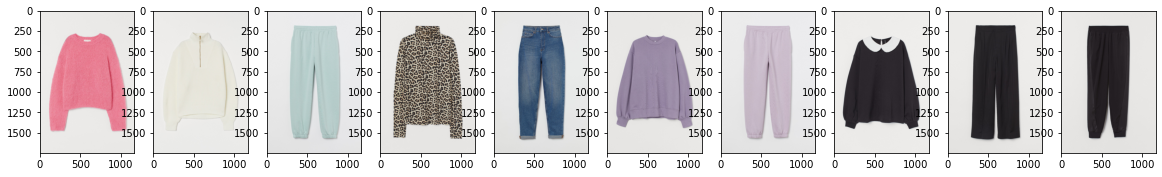

In [81]:
plot_purchase_history()

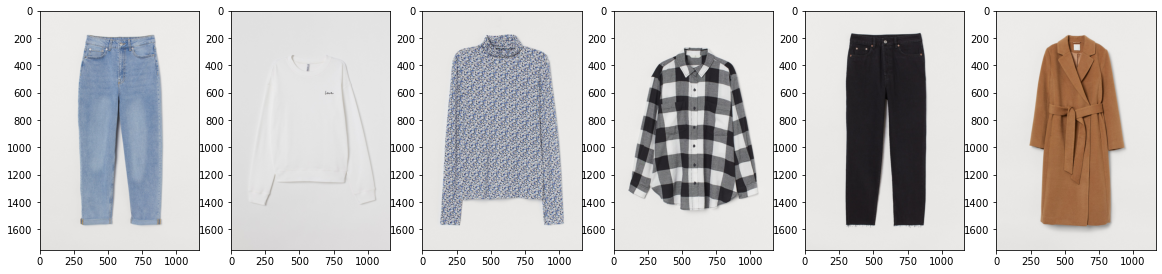

In [83]:
plot_recommendation()

https://www.kaggle.com/code/julian3833/h-m-implicit-als-model-0-014/notebook

In [113]:
cus = 2021

prev_items = groupby_customer.get_group(df_preds.iloc[cus,0])['article_id']
rcmnds_img = df_preds.iloc[cus,1].split()

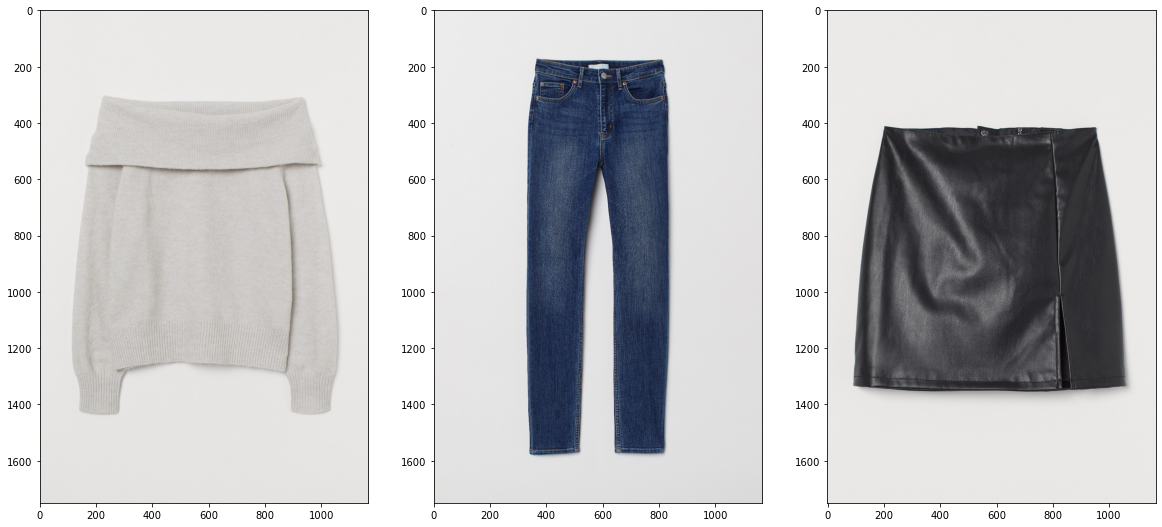

In [114]:
plot_purchase_history()

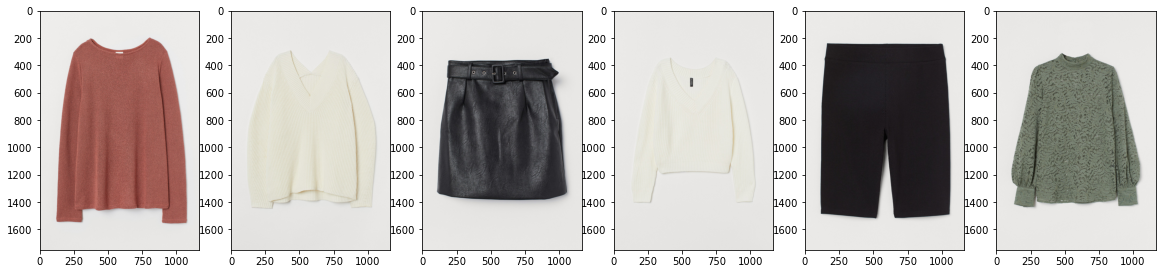

In [115]:
plot_recommendation()